<a href="https://colab.research.google.com/github/steinhaug/stable-diffusion/blob/main/BLIP-2/Chat_with_BLIP_2_%5Bint8_bitsandbytes%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chat with BLIP-2

In this notebook, we'll illustrate the new BLIP-2 model by Salesforce, which can be used for state-of-the-art image captioning, visual question answering and overall chatting related to images.

In this notebook, we'll showcase the [int8 quantization algorithm](https://huggingface.co/blog/hf-bitsandbytes-integration) by bitsandbytes, which allows to run giant model on fairly common hardware, like the hardware powering Google Colab.

## Set-up environment

We'll start by installing 🤗 Transformers. As the model is brand new at the time of writing this notebook, we install it from source.

Note that it's advised to run this notebook on a GPU environment, high RAM.

In [ ]:
!pip install git+https://github.com/huggingface/transformers
!pip install -q accelerate bitsandbytes

## Load image

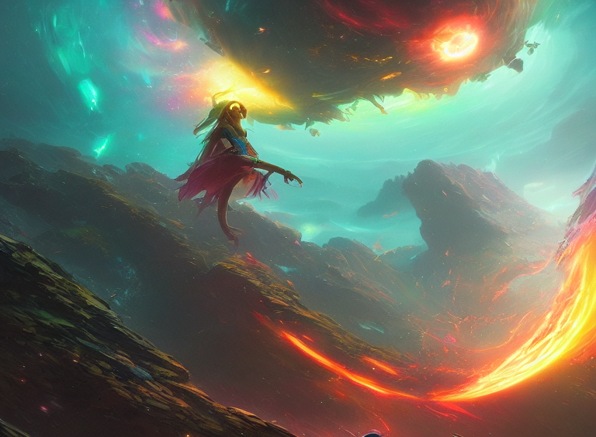

In [5]:
import requests
from PIL import Image

url = 'https://replicate.delivery/pbxt/SwBWBv61uHY5IhmdGEokbCdJi6AMbgK1slVXeyDBdvvGYPbIA/out-3.png' 
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')   
display(image.resize((596, 437)))

## Load model and processor

We can instantiate the model and its corresponding processor from the [hub](https://huggingface.co/models?other=blip-2). Here we load a BLIP-2 checkpoint that leverages the pre-trained OPT model by Meta AI, which as 2.7 billion parameters.

In [6]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")

# there are several ways to load the model:
# model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b") # load in float32
# model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16) # load in float16
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", device_map="auto", load_in_8bit=True) # load in int8

Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('8013'), PosixPath('//172.28.0.1'), PosixPath('http')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('--logtostderr --listen_host=172.28.0.12 --

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
!python -m bitsandbytes


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories 

Let's use the GPU, as it will make generation a lot faster.

In [8]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
## RELOAD image

#import requests
#from PIL import Image
#
#url = 'https://replicate.delivery/pbxt/TLeXNJzHq82XOaTMAXRPqgoBUVEwyCEVTsNy2If35bvzAfshA/out-3.png' 
#image = Image.open(requests.get(url, stream=True).raw).convert('RGB')   
#display(image.resize((596, 437)))

## Image captioning

If you don't provide any text prompt, then the model will by default start generating text from the BOS (beginning-of-sequence) token. So it will generate a caption for the image.

In [11]:
inputs = processor(image, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

a person standing in front of a giant planet


## Prompted image captioning

You can provide a text prompt, which the model will continue given the image.

In [12]:
prompt = "this is a picture of"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

a person standing in front of a giant planet


In [13]:
prompt = "the weather looks"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

like it is going to be a beautiful day


## Visual question answering (VQA)

In [ ]:
prompt = "Question: which city is this? Answer:"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=10)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

singapore


## Chat-based prompting

We can create a ChatGPT-like interface by simply concatenating each generated response to the conversation. We prompt the model with some text (like "which city is this?"), the model generates an answer for it "Singapore"), which we just concatenate to the conversation. Then we ask a follow-up question ("why?") which we also just concatenate and feed to the model.

This means that the context can't be too long - models like OPT and T5 (the language models being used in BLIP-2) have a context length of 512 tokens.

In [ ]:
context = [
    ("which city is this?", "singapore"),
    ("why?", "it has a statue of a merlion"),
]
question = "where is the name merlion coming from?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

print(prompt)

Question: which city is this? Answer: singapore. Question: why? Answer: it has a statue of a merlion. Question: where is the name merlion coming from? Answer:


In [ ]:
inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=10)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

merlion is a mythical creature from malays
